# Pedro Ribeiro

O desafio é **desenvolver uma solução para agrupar clientes baseado nos seus perfis de gastos**.
Para atingir esse objetivo, serão executados os seguintes passos:

1. Realizar uma análise exploratória profunda dos dados para entender as características e padrões de gastos dos clientes.
2. Criar uma nova feature que identifique se as transações se referem a gastos fixos ou variáveis.
3. Utilizar técnicas de clustering para segmentar os clientes em diferentes perfis de gastos.
4. Com base na análise exploratória, etiquetar cada cluster identificado com padrões de gastos quanto à quantidade, natureza (fixo/variado) e categoria da compra (como alimentação, saúde, lazer, etc.).
5. Responder às seguintes perguntas:
   - Quais os perfis de clientes que mais gastam proporcionalmente em gastos fixos?
   - Quais as categorias de compra que mais impactam nos perfis de gasto?
   - Quais são os perfis centrais (ou típicos) de cada cluster?

# Libraries

In [386]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import re
from dotenv import load_dotenv
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Dataframes

In [2]:
load_dotenv(".env")
path_dir = os.environ.get('path_dir')

In [4]:
os.chdir(path_dir)

In [176]:
accounts = pd.read_csv(os.getcwd()+'/data/accounts.csv')
display(accounts.head())
person = pd.read_csv(os.getcwd()+'/data/person.csv')
display(person.head())
transactions = pd.read_csv(os.getcwd()+'/data/transactions.csv')
display(transactions.head())

,id,type,subtype,balance,currency_code,name,person_id,account_id,date
0,1968bd13-dd25-4f88-bccc-5cff92d6811b,BANK,SAVINGS_ACCOUNT,3826.72,BRL,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-09-14 14:03:16
1,978f92cf-8d5b-437a-a046-cdaa9105624c,CREDIT,CREDIT_CARD,6311.67,BRL,Cartão de Crédito,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,978f92cf-8d5b-437a-a046-cdaa9105624c,2023-09-15 15:50:21
2,dcd96f70-8b16-42b0-a944-afec5d8305ce,CREDIT,CREDIT_CARD,7482.25,BRL,Cartão de Crédito,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,dcd96f70-8b16-42b0-a944-afec5d8305ce,2023-09-09 03:38:49
3,6c2a44fe-2ba7-4626-aaff-f244a0647eae,BANK,SAVINGS_ACCOUNT,5740.29,BRL,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,6c2a44fe-2ba7-4626-aaff-f244a0647eae,2023-09-12 14:21:21
4,abb359a2-3802-48e7-976b-8671e1de0884,BANK,CHECKING_ACCOUNT,5136.49,BRL,Conta Corrente,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,abb359a2-3802-48e7-976b-8671e1de0884,2023-09-12 04:10:04


,id,name,suitability
0,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,Ana Julia Santos,conservador
1,01018c18-ecb5-4cb6-b16f-bece97935974,Emilly Moura,moderado-agressivo
2,65d3336e-dafd-4663-8a53-97792c847074,Luiz Miguel Caldeira,conservador
3,6a33c027-13f2-4fbf-8bbb-74e6438d11c8,Sarah Souza,moderado-conservador
4,55252085-c5d6-4b7d-b221-fd3ad76ba8e5,Samuel Oliveira,moderado-agressivo


,id,currency_code,amount,date,category,account_id
0,b7ebd81b-98f7-47ab-91f3-52bc80be57a6,BRL,-498.71,2023-07-20 03:57:57,Educação,1968bd13-dd25-4f88-bccc-5cff92d6811b
1,b8d83679-02ab-4241-b15d-11e9c0033864,BRL,-265.00,2023-07-23 05:17:06,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b
2,99cab263-da5c-4706-9f2c-92cb779acaf7,BRL,-18.95,2023-06-26 05:54:25,Transporte,1968bd13-dd25-4f88-bccc-5cff92d6811b
3,5a78f1f0-f541-440f-9d3d-c8c21373ffc8,BRL,-262.70,2023-06-21 00:34:08,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b
4,fc4e9552-bb41-4757-8c16-ff2c584ee01b,BRL,-179.44,2023-08-05 01:09:42,"Imposto, juros e multa",1968bd13-dd25-4f88-bccc-5cff92d6811b


In [177]:
are_columns_equal = accounts['id'].equals(accounts['account_id'])
are_columns_equal

True

In [178]:
print(accounts.currency_code.unique())
print(transactions.currency_code.unique())

['BRL']
['BRL']


In [179]:
accounts.drop('currency_code', axis='columns', inplace=True)
accounts.drop('account_id', axis='columns', inplace=True)
transactions.drop('currency_code', axis='columns', inplace=True)

In [180]:
display(accounts.head())
display(person.head())
display(transactions.head())

,id,type,subtype,balance,name,person_id,date
0,1968bd13-dd25-4f88-bccc-5cff92d6811b,BANK,SAVINGS_ACCOUNT,3826.72,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-14 14:03:16
1,978f92cf-8d5b-437a-a046-cdaa9105624c,CREDIT,CREDIT_CARD,6311.67,Cartão de Crédito,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-15 15:50:21
2,dcd96f70-8b16-42b0-a944-afec5d8305ce,CREDIT,CREDIT_CARD,7482.25,Cartão de Crédito,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-09 03:38:49
3,6c2a44fe-2ba7-4626-aaff-f244a0647eae,BANK,SAVINGS_ACCOUNT,5740.29,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-12 14:21:21
4,abb359a2-3802-48e7-976b-8671e1de0884,BANK,CHECKING_ACCOUNT,5136.49,Conta Corrente,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-12 04:10:04


,id,name,suitability
0,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,Ana Julia Santos,conservador
1,01018c18-ecb5-4cb6-b16f-bece97935974,Emilly Moura,moderado-agressivo
2,65d3336e-dafd-4663-8a53-97792c847074,Luiz Miguel Caldeira,conservador
3,6a33c027-13f2-4fbf-8bbb-74e6438d11c8,Sarah Souza,moderado-conservador
4,55252085-c5d6-4b7d-b221-fd3ad76ba8e5,Samuel Oliveira,moderado-agressivo


,id,amount,date,category,account_id
0,b7ebd81b-98f7-47ab-91f3-52bc80be57a6,-498.71,2023-07-20 03:57:57,Educação,1968bd13-dd25-4f88-bccc-5cff92d6811b
1,b8d83679-02ab-4241-b15d-11e9c0033864,-265.00,2023-07-23 05:17:06,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b
2,99cab263-da5c-4706-9f2c-92cb779acaf7,-18.95,2023-06-26 05:54:25,Transporte,1968bd13-dd25-4f88-bccc-5cff92d6811b
3,5a78f1f0-f541-440f-9d3d-c8c21373ffc8,-262.70,2023-06-21 00:34:08,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b
4,fc4e9552-bb41-4757-8c16-ff2c584ee01b,-179.44,2023-08-05 01:09:42,"Imposto, juros e multa",1968bd13-dd25-4f88-bccc-5cff92d6811b


# Exploratory analysis

### 1. Caracteristicas gerais dos dados - Univariada

Primeiramente irei realizar uma análise exploratóiria para cada variável de cada um dos datasets separadamente para entender o comportamento geral e verificar valores faltantes

### Person

In [181]:
person.shape

(2531, 3)

In [182]:
display(person.head())
display(person.tail())

,id,name,suitability
0,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,Ana Julia Santos,conservador
1,01018c18-ecb5-4cb6-b16f-bece97935974,Emilly Moura,moderado-agressivo
2,65d3336e-dafd-4663-8a53-97792c847074,Luiz Miguel Caldeira,conservador
3,6a33c027-13f2-4fbf-8bbb-74e6438d11c8,Sarah Souza,moderado-conservador
4,55252085-c5d6-4b7d-b221-fd3ad76ba8e5,Samuel Oliveira,moderado-agressivo


,id,name,suitability
2526,39f66a6b-1a60-4ee5-b186-3c0e7400004b,Kevin da Conceição,conservador
2527,5050325b-5bcd-40a3-a6ac-5f14ada7dc5b,Lara da Mota,agressivo
2528,480997ba-051c-46b1-90d1-c5e99686351d,Sr. Guilherme Peixoto,moderado
2529,526c75ce-fcc9-405a-8e6a-15b6c9cde719,Enzo Nascimento,NaN
2530,fabc96ce-3723-42dc-8cbe-0aba93fcd773,Maria Clara Pereira,conservador


In [183]:
person.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2531 entries, 0 to 2530
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           2531 non-null   object
 1   name         2531 non-null   object
 2   suitability  2084 non-null   object
dtypes: object(3)
memory usage: 59.4+ KB


In [184]:
person.duplicated().sum()

0

In [185]:
filtered_null_suitability = person[person['suitability'].isnull()]
filtered_null_suitability

,id,name,suitability
13,6af9c508-a57a-43cb-9ab3-2aecf18f5cea,Ana Beatriz Jesus,NaN
14,cf0c52f9-5542-495d-b1f3-02b83366c861,Lavínia Farias,NaN
16,3b273d75-dbc5-4b87-9cf0-1fe0587b349c,Luiz Otávio Azevedo,NaN
32,1ce95f5d-eaf8-464c-9809-e98eb44bebf2,Maria Julia Silva,NaN
34,d3f7da64-ef01-441f-9cbd-7c22534f586c,Srta. Rebeca da Rocha,NaN
...,...,...,...
2505,197280f3-84a2-4167-bab4-bd7f7375abce,Luiz Felipe Rocha,NaN
2507,069ea8f2-f744-4aeb-a320-fb576c50229b,Otávio Cunha,NaN
2520,b50fa919-195d-479b-911d-efc9889ca4c1,Breno Lopes,NaN
2521,9717e592-5fcc-4f58-8b69-5602e79fc16f,André Peixoto,NaN


In [186]:
print(f"The dataframe has {len(filtered_null_suitability)} missing values in the suitability of a total of {len(person)}: {round((len(filtered_null_suitability)/len(person)*100),1)}%")

The dataframe has 447 missing values in the suitability of a total of 2531: 17.7%


In [187]:
person['suitability'].fillna("no_suitability", inplace=True)

no_suitability          447
agressivo               444
conservador             422
moderado-agressivo      420
moderado                410
moderado-conservador    388
Name: suitability, dtype: int64

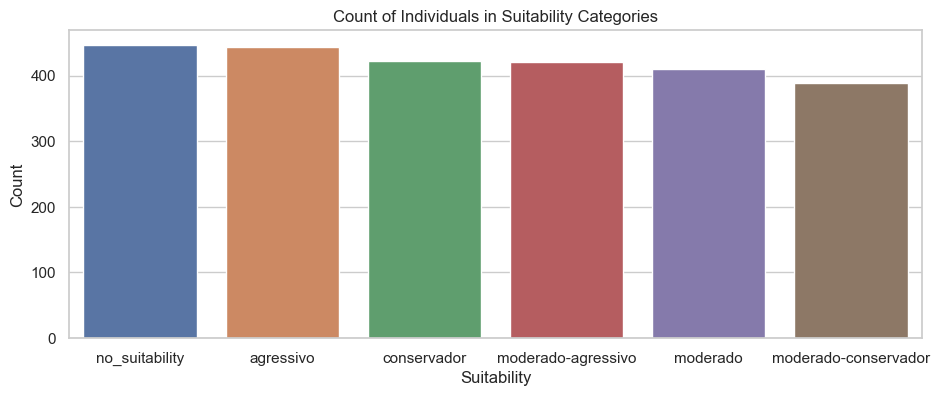

In [351]:
display(person["suitability"].value_counts())

plt.figure(figsize=(11, 4))
sns.barplot(y=person["suitability"].value_counts().values, 
            x=person["suitability"].value_counts().index)
plt.xlabel('Suitability')
plt.ylabel('Count')
plt.title('Count of Individuals in Suitability Categories')
plt.show()

agressivo               444
conservador             422
moderado-agressivo      420
moderado                410
moderado-conservador    388
Name: suitability, dtype: int64

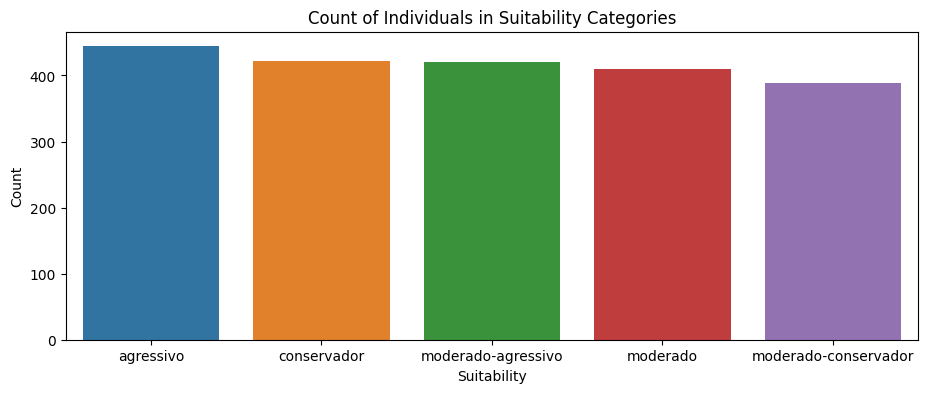

In [195]:
display(person[person["suitability"] != "no_suitability"]["suitability"].value_counts())

plt.figure(figsize=(11, 4))
sns.barplot(y=person[person["suitability"] != "no_suitability"]["suitability"].value_counts().values, 
            x=person[person["suitability"] != "no_suitability"]["suitability"].value_counts().index)
plt.xlabel('Suitability')
plt.ylabel('Count')
plt.title('Count of Individuals in Suitability Categories')
plt.show()

In [19]:
def has_non_letter(string):
    pattern = r'[^a-zA-Záàâãéèêíïóôõöúçñ\s]'
    return bool(re.search(pattern, string))

strings = person.name

for string in strings:
    if has_non_letter(string):
        print(f"'{string}' contains non-letter characters.")
    pass

'Dr. Gustavo Henrique Viana' contains non-letter characters.
'Sr. Erick Rezende' contains non-letter characters.
'Dr. Lucca Moraes' contains non-letter characters.
'Srta. Rebeca da Rocha' contains non-letter characters.
'Srta. Maria Fernanda Castro' contains non-letter characters.
'Sr. Otávio Porto' contains non-letter characters.
'Srta. Sophia Pereira' contains non-letter characters.
'Dra. Rafaela Barros' contains non-letter characters.
'Dra. Sarah Freitas' contains non-letter characters.
'Srta. Lívia Pinto' contains non-letter characters.
'Dra. Laís Rezende' contains non-letter characters.
'Sra. Gabriela Nunes' contains non-letter characters.
'Sr. Pedro Henrique Duarte' contains non-letter characters.
'Srta. Camila Farias' contains non-letter characters.
'Dr. Marcelo Dias' contains non-letter characters.
'Sra. Sophia Viana' contains non-letter characters.
'Dra. Ana Julia das Neves' contains non-letter characters.
'Srta. Sofia Barbosa' contains non-letter characters.
'Sra. Rebeca Pire

In [68]:
# Retirando os pronomes dos nome dos clientes no intúito de limpar os dados  
person['person_name'] = person['name'].apply(lambda x: x.split(". ")[1] if x.startswith("Dr. ") or x.startswith("Dra. ") or x.startswith("Sr. ") or x.startswith("Sra. ") or x.startswith("Srta. ") else x)

In [21]:
strings = person.person_name

for string in strings:
    if has_non_letter(string):
        print(f"'{string}' contains non-letter characters.")
    pass

In [76]:
print("""
Constatado que possuem nomes repetitos no banco de dados. Caso precise utilizar o nome de cada cliente, o 
melhor será utilizar o id de identificação de cada cliente pois é único
""")
person.describe()


Constatado que possuem nomes repetitos no banco de dados. Caso precise utilizar o nome de cada cliente, o 
melhor será utilizar o id de identificação de cada cliente pois é único



,id,name,suitability,person_name
count,2531,2531,2084,2531
unique,2531,2374,5,2313
top,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,Felipe Peixoto,agressivo,Ana Castro
freq,1,3,444,3


### Accounts

In [23]:
accounts.shape

(7569, 7)

In [24]:
display(accounts.head())
display(accounts.tail())

,id,type,subtype,balance,name,person_id,date
0,1968bd13-dd25-4f88-bccc-5cff92d6811b,BANK,SAVINGS_ACCOUNT,3826.72,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-14 14:03:16
1,978f92cf-8d5b-437a-a046-cdaa9105624c,CREDIT,CREDIT_CARD,6311.67,Cartão de Crédito,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-15 15:50:21
2,dcd96f70-8b16-42b0-a944-afec5d8305ce,CREDIT,CREDIT_CARD,7482.25,Cartão de Crédito,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-09 03:38:49
3,6c2a44fe-2ba7-4626-aaff-f244a0647eae,BANK,SAVINGS_ACCOUNT,5740.29,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-12 14:21:21
4,abb359a2-3802-48e7-976b-8671e1de0884,BANK,CHECKING_ACCOUNT,5136.49,Conta Corrente,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-12 04:10:04


,id,type,subtype,balance,name,person_id,date
7564,88f496c6-eac6-422f-8a4d-e88ca3fe0351,BANK,SAVINGS_ACCOUNT,12044.12,Poupança,fabc96ce-3723-42dc-8cbe-0aba93fcd773,2023-09-15 00:33:21
7565,e3ca889d-2b1c-464a-be4f-b7719822ba98,CREDIT,CREDIT_CARD,12351.60,Cartão de Crédito,fabc96ce-3723-42dc-8cbe-0aba93fcd773,2023-09-14 22:11:53
7566,c64d8afc-409f-446e-a19c-a8c9c0c5e57b,CREDIT,CREDIT_CARD,9555.10,Cartão de Crédito,fabc96ce-3723-42dc-8cbe-0aba93fcd773,2023-08-29 17:30:32
7567,8c709383-2d35-4796-995f-3eea8e7fefd9,CREDIT,CREDIT_CARD,5044.89,Cartão de Crédito,fabc96ce-3723-42dc-8cbe-0aba93fcd773,2023-09-15 10:06:56
7568,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,BANK,SAVINGS_ACCOUNT,3788.95,Poupança,fabc96ce-3723-42dc-8cbe-0aba93fcd773,2023-09-15 07:21:03


In [67]:
accounts.info()
# Não possuem valores Null

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7569 entries, 0 to 7568
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         7569 non-null   object 
 1   type       7569 non-null   object 
 2   subtype    7569 non-null   object 
 3   balance    7569 non-null   float64
 4   name       7569 non-null   object 
 5   person_id  7569 non-null   object 
 6   date       7569 non-null   object 
dtypes: float64(1), object(6)
memory usage: 414.1+ KB


In [26]:
accounts.duplicated().sum()

0

In [27]:
accounts.columns

Index(['id', 'type', 'subtype', 'balance', 'name', 'person_id', 'date'], dtype='object')

In [281]:
print("max", accounts.date.max())
print("min", accounts.date.min())

max 2023-09-15 16:27:42
min 2023-06-20 09:07:52


In [28]:
accounts.describe()

,balance
count,7569.000000
mean,5717.472539
std,4825.408916
min,11.520000
25%,2514.880000
50%,5021.490000
75%,7558.410000
max,44965.250000


BANK      4950
CREDIT    2619
Name: type, dtype: int64

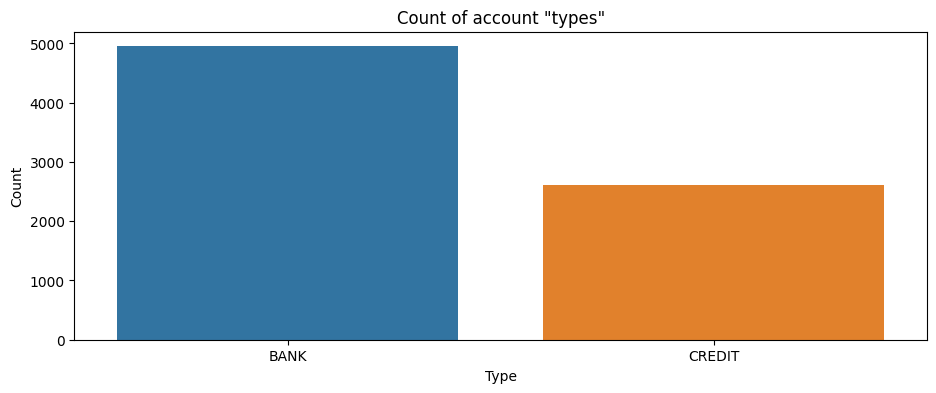

In [82]:
display(accounts["type"].value_counts())

plt.figure(figsize=(11, 4))
sns.barplot(y=accounts["type"].value_counts().values, x=accounts["type"].value_counts().index)
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Count of account "types"')
plt.show()

CREDIT_CARD         2619
CHECKING_ACCOUNT    2509
SAVINGS_ACCOUNT     2441
Name: subtype, dtype: int64

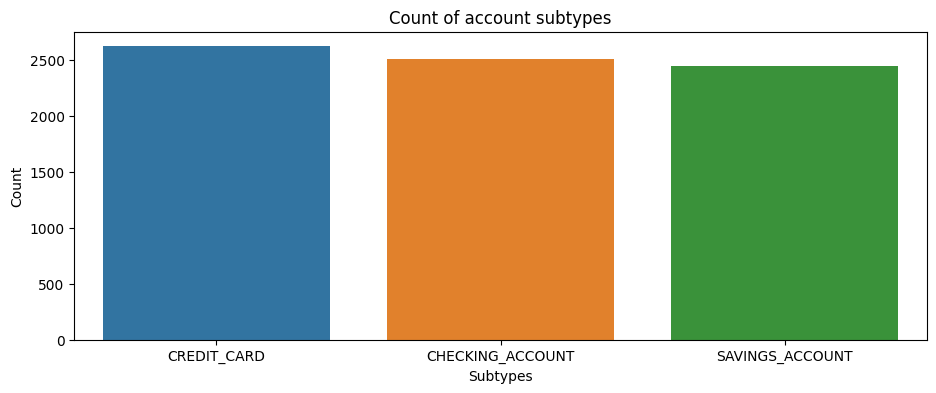

In [81]:
display(accounts["subtype"].value_counts())

plt.figure(figsize=(11, 4))
sns.barplot(y=accounts["subtype"].value_counts().values, x=accounts["subtype"].value_counts().index)
plt.xlabel('Subtypes')
plt.ylabel('Count')
plt.title('Count of account subtypes')
plt.show()

Cartão de Crédito    2619
Conta Corrente       2509
Poupança              845
Conta Remunerada      804
Caixinha              792
Name: name, dtype: int64

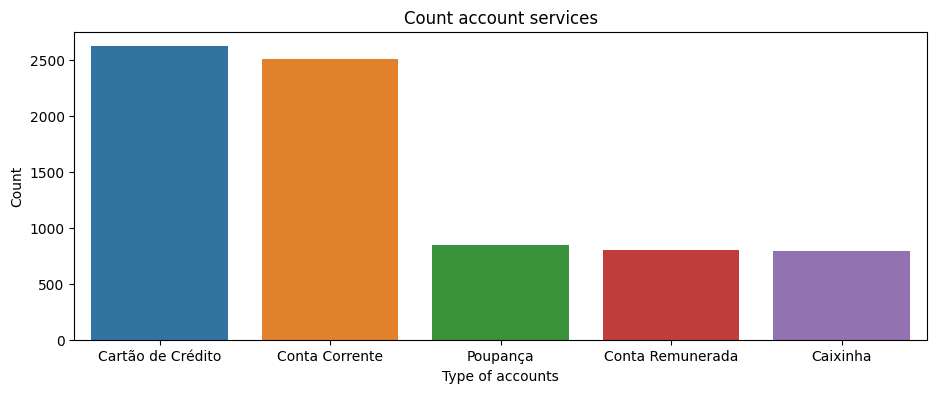

In [83]:
display(accounts["name"].value_counts())

plt.figure(figsize=(11, 4))
sns.barplot(y=accounts["name"].value_counts().values, x=accounts["name"].value_counts().index)
plt.xlabel('Type of accounts')
plt.ylabel('Count')
plt.title('Count account services')
plt.show()

<AxesSubplot: >

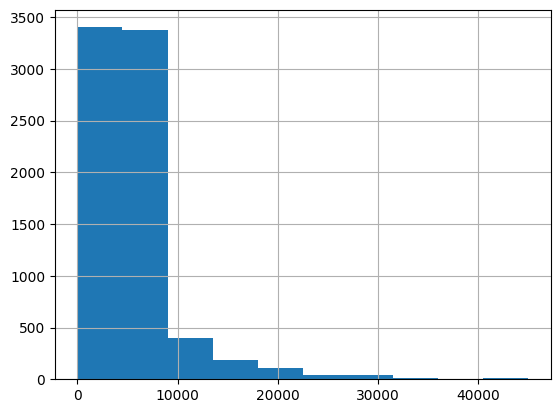

In [32]:
accounts.balance.hist()

### Transactions

In [33]:
transactions.shape

(400110, 5)

In [34]:
display(transactions.head())
display(transactions.tail())

,id,amount,date,category,account_id
0,b7ebd81b-98f7-47ab-91f3-52bc80be57a6,-498.71,2023-07-20 03:57:57,Educação,1968bd13-dd25-4f88-bccc-5cff92d6811b
1,b8d83679-02ab-4241-b15d-11e9c0033864,-265.00,2023-07-23 05:17:06,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b
2,99cab263-da5c-4706-9f2c-92cb779acaf7,-18.95,2023-06-26 05:54:25,Transporte,1968bd13-dd25-4f88-bccc-5cff92d6811b
3,5a78f1f0-f541-440f-9d3d-c8c21373ffc8,-262.70,2023-06-21 00:34:08,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b
4,fc4e9552-bb41-4757-8c16-ff2c584ee01b,-179.44,2023-08-05 01:09:42,"Imposto, juros e multa",1968bd13-dd25-4f88-bccc-5cff92d6811b


,id,amount,date,category,account_id
400105,95d79cc9-988c-4811-81f8-ffe910092074,2185.20,2022-12-02 19:42:10,Recebido,df03df9a-b7e3-4ee3-b2d5-50275e41afcf
400106,eac2684b-c13b-44c2-8efb-79fbf9c4cd75,2274.47,2023-07-22 11:48:20,Recebido,7dbe31db-bad3-4820-91c1-94e85a44a7aa
400107,f1452582-06f3-47ce-bb13-2a2adb8a6cbe,7328.84,2023-07-24 23:06:28,Recebido,a67cf9c0-9209-47b7-89dc-cc06c4c39d81
400108,1db037b4-fe8c-48f5-92f0-10c753f5330f,7328.84,2023-06-25 19:13:28,Recebido,a67cf9c0-9209-47b7-89dc-cc06c4c39d81
400109,c2b4de56-d6bc-4b4f-b7c5-4c0aea79a129,5081.83,2023-06-17 22:57:04,Recebido,1d6c9df7-a0aa-4435-a6a9-97590c05d52c


In [35]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400110 entries, 0 to 400109
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          400110 non-null  object 
 1   amount      400110 non-null  float64
 2   date        400110 non-null  object 
 3   category    368501 non-null  object 
 4   account_id  400110 non-null  object 
dtypes: float64(1), object(4)
memory usage: 15.3+ MB


In [282]:
print("max", transactions.date.max())
print("min", transactions.date.min())

max 2023-09-15 16:27:42
min 2022-01-03 01:46:38


In [36]:
filtered_null_category = transactions[transactions['category'].isnull()]
filtered_null_category

,id,amount,date,category,account_id
8,437feea8-3afd-4f2f-9c98-91de4575b57b,-1258.65,2023-06-19 13:01:15,NaN,1968bd13-dd25-4f88-bccc-5cff92d6811b
12,ef335bda-b208-40b3-abee-46de72b5a0b3,-199.70,2023-06-22 15:05:15,NaN,1968bd13-dd25-4f88-bccc-5cff92d6811b
68,96b1c62c-e319-40e5-a201-69432b145fd3,-535.54,2023-08-16 01:39:32,NaN,978f92cf-8d5b-437a-a046-cdaa9105624c
76,024227f9-af91-4ce0-b4e7-d6d243dd9153,-2436.43,2023-09-13 10:12:24,NaN,978f92cf-8d5b-437a-a046-cdaa9105624c
87,c12a1b96-92d2-4541-bb85-472959819a30,-1786.20,2023-08-27 12:45:15,NaN,978f92cf-8d5b-437a-a046-cdaa9105624c
...,...,...,...,...,...
380109,111d167f-9ba0-4918-a689-0db641cb8f46,-7351.86,2023-09-03 02:10:37,NaN,e3ca889d-2b1c-464a-be4f-b7719822ba98
380113,b6929181-a07a-42d1-a32e-6ddafc2774be,-1426.42,2023-08-23 00:54:10,NaN,e3ca889d-2b1c-464a-be4f-b7719822ba98
380145,52ce02f0-321e-4c30-9cdf-387aa0b67413,-6277.14,2023-08-11 16:52:35,NaN,8c709383-2d35-4796-995f-3eea8e7fefd9
380158,9d7623d3-9ef3-4151-ae50-6e72fee99634,-4825.69,2023-07-26 22:55:52,NaN,9ba71d75-2913-4b7b-b2e8-48acbd23c36b


In [51]:
print(f"The dataframe has {len(filtered_null_category)} missing values in the suitability of a total of {len(transactions)}: {round((len(filtered_null_category)/len(transactions)*100),1)}%")

The dataframe has 31609 missing values in the suitability of a total of 400110: 7.9%


In [196]:
transactions['category'].fillna("no_category", inplace=True)

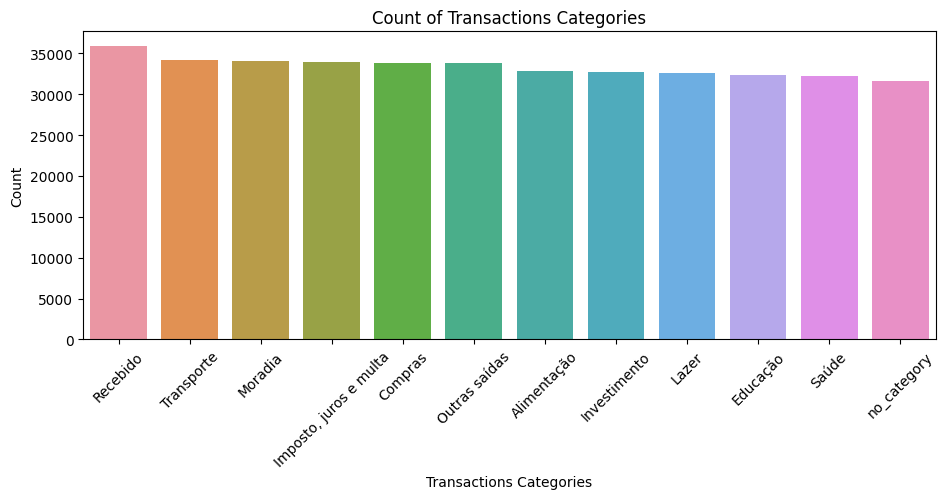

In [197]:
transactions["category"].value_counts()

plt.figure(figsize=(11, 4))
sns.barplot(y=transactions["category"].value_counts().values, x=transactions["category"].value_counts().index)
plt.xlabel('Transactions Categories')
plt.ylabel('Count')
plt.title('Count of Transactions Categories')
plt.xticks(rotation=45)
plt.show()

In [38]:
transactions.describe()

,amount
count,400110.000000
mean,-490.874337
std,2011.405745
min,-29334.350000
25%,-997.315000
50%,-328.800000
75%,-79.600000
max,17764.300000


In [39]:
transactions.duplicated().sum()

0

<AxesSubplot: >

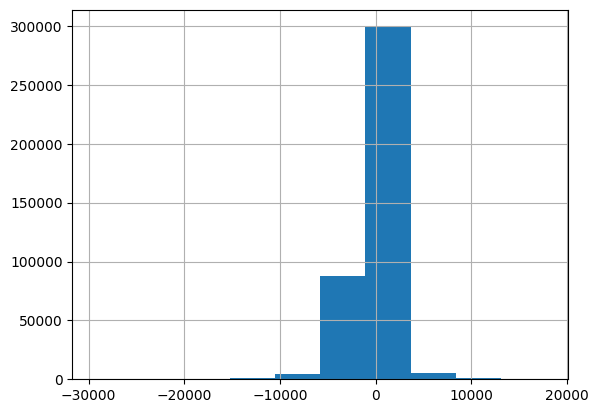

In [40]:
transactions.amount.hist()

# Merge dataframes

In [41]:
merged_accounts = pd.merge(person, accounts, left_on="id", right_on="person_id", how="left", suffixes=("_person", "_acc"))

In [42]:
merged_accounts

,id_person,name_person,suitability,person_name,id_acc,type,subtype,balance,name_acc,person_id,date
0,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,Ana Julia Santos,conservador,Ana Julia Santos,1968bd13-dd25-4f88-bccc-5cff92d6811b,BANK,SAVINGS_ACCOUNT,3826.72,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-14 14:03:16
1,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,Ana Julia Santos,conservador,Ana Julia Santos,978f92cf-8d5b-437a-a046-cdaa9105624c,CREDIT,CREDIT_CARD,6311.67,Cartão de Crédito,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-15 15:50:21
2,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,Ana Julia Santos,conservador,Ana Julia Santos,dcd96f70-8b16-42b0-a944-afec5d8305ce,CREDIT,CREDIT_CARD,7482.25,Cartão de Crédito,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-09 03:38:49
3,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,Ana Julia Santos,conservador,Ana Julia Santos,6c2a44fe-2ba7-4626-aaff-f244a0647eae,BANK,SAVINGS_ACCOUNT,5740.29,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-12 14:21:21
4,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,Ana Julia Santos,conservador,Ana Julia Santos,abb359a2-3802-48e7-976b-8671e1de0884,BANK,CHECKING_ACCOUNT,5136.49,Conta Corrente,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-12 04:10:04
...,...,...,...,...,...,...,...,...,...,...,...
7564,fabc96ce-3723-42dc-8cbe-0aba93fcd773,Maria Clara Pereira,conservador,Maria Clara Pereira,88f496c6-eac6-422f-8a4d-e88ca3fe0351,BANK,SAVINGS_ACCOUNT,12044.12,Poupança,fabc96ce-3723-42dc-8cbe-0aba93fcd773,2023-09-15 00:33:21
7565,fabc96ce-3723-42dc-8cbe-0aba93fcd773,Maria Clara Pereira,conservador,Maria Clara Pereira,e3ca889d-2b1c-464a-be4f-b7719822ba98,CREDIT,CREDIT_CARD,12351.60,Cartão de Crédito,fabc96ce-3723-42dc-8cbe-0aba93fcd773,2023-09-14 22:11:53
7566,fabc96ce-3723-42dc-8cbe-0aba93fcd773,Maria Clara Pereira,conservador,Maria Clara Pereira,c64d8afc-409f-446e-a19c-a8c9c0c5e57b,CREDIT,CREDIT_CARD,9555.10,Cartão de Crédito,fabc96ce-3723-42dc-8cbe-0aba93fcd773,2023-08-29 17:30:32
7567,fabc96ce-3723-42dc-8cbe-0aba93fcd773,Maria Clara Pereira,conservador,Maria Clara Pereira,8c709383-2d35-4796-995f-3eea8e7fefd9,CREDIT,CREDIT_CARD,5044.89,Cartão de Crédito,fabc96ce-3723-42dc-8cbe-0aba93fcd773,2023-09-15 10:06:56


In [49]:
merged_accounts.shape

(7569, 11)

In [43]:
merged_data_total = pd.merge(merged_accounts, transactions, left_on="id_acc", right_on="account_id", how="left", suffixes=("", "_trans"))

In [44]:
merged_data_total.shape

(400110, 16)

In [45]:
display(merged_data_total.head())
display(merged_data_total.tail())

,id_person,name_person,suitability,person_name,id_acc,type,subtype,balance,name_acc,person_id,date,id,amount,date_trans,category,account_id
0,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,Ana Julia Santos,conservador,Ana Julia Santos,1968bd13-dd25-4f88-bccc-5cff92d6811b,BANK,SAVINGS_ACCOUNT,3826.72,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-14 14:03:16,b7ebd81b-98f7-47ab-91f3-52bc80be57a6,-498.71,2023-07-20 03:57:57,Educação,1968bd13-dd25-4f88-bccc-5cff92d6811b
1,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,Ana Julia Santos,conservador,Ana Julia Santos,1968bd13-dd25-4f88-bccc-5cff92d6811b,BANK,SAVINGS_ACCOUNT,3826.72,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-14 14:03:16,b8d83679-02ab-4241-b15d-11e9c0033864,-265.00,2023-07-23 05:17:06,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b
2,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,Ana Julia Santos,conservador,Ana Julia Santos,1968bd13-dd25-4f88-bccc-5cff92d6811b,BANK,SAVINGS_ACCOUNT,3826.72,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-14 14:03:16,99cab263-da5c-4706-9f2c-92cb779acaf7,-18.95,2023-06-26 05:54:25,Transporte,1968bd13-dd25-4f88-bccc-5cff92d6811b
3,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,Ana Julia Santos,conservador,Ana Julia Santos,1968bd13-dd25-4f88-bccc-5cff92d6811b,BANK,SAVINGS_ACCOUNT,3826.72,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-14 14:03:16,5a78f1f0-f541-440f-9d3d-c8c21373ffc8,-262.70,2023-06-21 00:34:08,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b
4,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,Ana Julia Santos,conservador,Ana Julia Santos,1968bd13-dd25-4f88-bccc-5cff92d6811b,BANK,SAVINGS_ACCOUNT,3826.72,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-14 14:03:16,fc4e9552-bb41-4757-8c16-ff2c584ee01b,-179.44,2023-08-05 01:09:42,"Imposto, juros e multa",1968bd13-dd25-4f88-bccc-5cff92d6811b


,id_person,name_person,suitability,person_name,id_acc,type,subtype,balance,name_acc,person_id,date,id,amount,date_trans,category,account_id
400105,fabc96ce-3723-42dc-8cbe-0aba93fcd773,Maria Clara Pereira,conservador,Maria Clara Pereira,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,BANK,SAVINGS_ACCOUNT,3788.95,Poupança,fabc96ce-3723-42dc-8cbe-0aba93fcd773,2023-09-15 07:21:03,d1297b29-1168-4f15-b856-fc252375d4f7,-735.58,2023-06-20 15:23:59,Lazer,9ba71d75-2913-4b7b-b2e8-48acbd23c36b
400106,fabc96ce-3723-42dc-8cbe-0aba93fcd773,Maria Clara Pereira,conservador,Maria Clara Pereira,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,BANK,SAVINGS_ACCOUNT,3788.95,Poupança,fabc96ce-3723-42dc-8cbe-0aba93fcd773,2023-09-15 07:21:03,bf174dd6-91b9-4b52-b847-cf814accdb07,-1205.81,2023-07-12 21:32:39,Saúde,9ba71d75-2913-4b7b-b2e8-48acbd23c36b
400107,fabc96ce-3723-42dc-8cbe-0aba93fcd773,Maria Clara Pereira,conservador,Maria Clara Pereira,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,BANK,SAVINGS_ACCOUNT,3788.95,Poupança,fabc96ce-3723-42dc-8cbe-0aba93fcd773,2023-09-15 07:21:03,b6714ac1-9299-4fb0-bfe8-4ce4bc98604f,-921.22,2023-07-27 11:48:53,Saúde,9ba71d75-2913-4b7b-b2e8-48acbd23c36b
400108,fabc96ce-3723-42dc-8cbe-0aba93fcd773,Maria Clara Pereira,conservador,Maria Clara Pereira,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,BANK,SAVINGS_ACCOUNT,3788.95,Poupança,fabc96ce-3723-42dc-8cbe-0aba93fcd773,2023-09-15 07:21:03,35c6a2bd-c6d7-450a-910b-cf323b444dbf,-2767.55,2023-07-23 07:10:14,Compras,9ba71d75-2913-4b7b-b2e8-48acbd23c36b
400109,fabc96ce-3723-42dc-8cbe-0aba93fcd773,Maria Clara Pereira,conservador,Maria Clara Pereira,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,BANK,SAVINGS_ACCOUNT,3788.95,Poupança,fabc96ce-3723-42dc-8cbe-0aba93fcd773,2023-09-15 07:21:03,d52a9f5e-840f-47f2-a9d5-5c45e6086754,1970.78,2023-07-09 11:22:05,Investimento,9ba71d75-2913-4b7b-b2e8-48acbd23c36b


In [46]:
merged_data_total.describe()

,balance,amount
count,400110.000000,400110.000000
mean,5688.566108,-490.874337
std,4758.308835,2011.405745
min,11.520000,-29334.350000
25%,2540.750000,-997.315000
50%,5045.500000,-328.800000
75%,7566.560000,-79.600000
max,44965.250000,17764.300000


In [285]:
print('max', merged_data_total.date_trans.max())
print('min', merged_data_total.date_trans.min())

max 2023-09-15 16:27:42
min 2022-01-03 01:46:38


In [47]:
merged_data_tortal_s_trans = merged_data_total[['id_person', 'name_person', 'suitability', "person_name", "id_acc","type", "subtype", "balance", "name_acc", "person_id",	'date']]

In [48]:
merged_data_tortal_s_trans.drop_duplicates().describe()

,balance
count,7569.000000
mean,5717.472539
std,4825.408916
min,11.520000
25%,2514.880000
50%,5021.490000
75%,7558.410000
max,44965.250000


### 1. Analise exploratória padrões de gasto

In [258]:
merged_data_total.columns

Index(['id_person', 'name_person', 'suitability', 'person_name', 'id_acc',
       'type', 'subtype', 'balance', 'name_acc', 'person_id', 'date', 'id',
       'amount', 'date_trans', 'category', 'account_id'],
      dtype='object')

In [305]:
merged_data_total['date'] = pd.to_datetime(merged_data_total['date_trans'])
merged_data_total['month'] =merged_data_total['date'].dt.month
merged_data_total['year'] = merged_data_total['date'].dt.year
merged_data_total['year_month'] = merged_data_total['year'].astype(str) + "/" + merged_data_total['month'].astype(str)

In [286]:
a = merged_data_total[['id_person', 'suitability', 'type', 'subtype', 'balance', 
                   "name_acc",'id','amount', 'date_trans', 'category', 'account_id' ]]

In [287]:
a['date'] = pd.to_datetime(a['date_trans'])
a['month'] = a['date'].dt.month
a['year'] = a['date'].dt.year
a['year_month'] = a['year'].astype(str) + "/" + a['month'].astype(str)

C:\Users\pedro\AppData\Local\Temp\ipykernel_22020\2001718585.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['date'] = pd.to_datetime(a['date_trans'])
C:\Users\pedro\AppData\Local\Temp\ipykernel_22020\2001718585.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['month'] = a['date'].dt.month
C:\Users\pedro\AppData\Local\Temp\ipykernel_22020\2001718585.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [294]:
a_gasto = a[a.amount < 0]
b = a_gasto.groupby(['id_person', 'suitability', 'type', 'subtype', 
                 'category','account_id', 'year_month'])[['amount']].sum().reset_index()

In [295]:
b

,id_person,suitability,type,subtype,category,account_id,year_month,amount
0,000be23a-894b-4eca-aa31-5373556f8204,moderado,BANK,SAVINGS_ACCOUNT,Alimentação,e1368c04-175a-40f6-9d31-956e7e00ff17,2023/7,-337.80
1,000be23a-894b-4eca-aa31-5373556f8204,moderado,BANK,SAVINGS_ACCOUNT,Alimentação,e1368c04-175a-40f6-9d31-956e7e00ff17,2023/8,-294.11
2,000be23a-894b-4eca-aa31-5373556f8204,moderado,BANK,SAVINGS_ACCOUNT,Alimentação,e1368c04-175a-40f6-9d31-956e7e00ff17,2023/9,-99.25
3,000be23a-894b-4eca-aa31-5373556f8204,moderado,BANK,SAVINGS_ACCOUNT,Compras,60a08029-aae2-4b0f-ba97-913eb52c4688,2023/8,-6560.55
4,000be23a-894b-4eca-aa31-5373556f8204,moderado,BANK,SAVINGS_ACCOUNT,Compras,e1368c04-175a-40f6-9d31-956e7e00ff17,2023/7,-3624.30
...,...,...,...,...,...,...,...,...
131158,ffe36cb3-c406-46dd-931e-0b38143a1b7c,agressivo,CREDIT,CREDIT_CARD,Saúde,bb80934d-3f37-4eb8-a693-0400195ab2d0,2023/8,-464.15
131159,ffe36cb3-c406-46dd-931e-0b38143a1b7c,agressivo,CREDIT,CREDIT_CARD,Transporte,bb80934d-3f37-4eb8-a693-0400195ab2d0,2023/5,-313.18
131160,ffe36cb3-c406-46dd-931e-0b38143a1b7c,agressivo,CREDIT,CREDIT_CARD,Transporte,bb80934d-3f37-4eb8-a693-0400195ab2d0,2023/6,-156.59
131161,ffe36cb3-c406-46dd-931e-0b38143a1b7c,agressivo,CREDIT,CREDIT_CARD,Transporte,bb80934d-3f37-4eb8-a693-0400195ab2d0,2023/7,-355.84


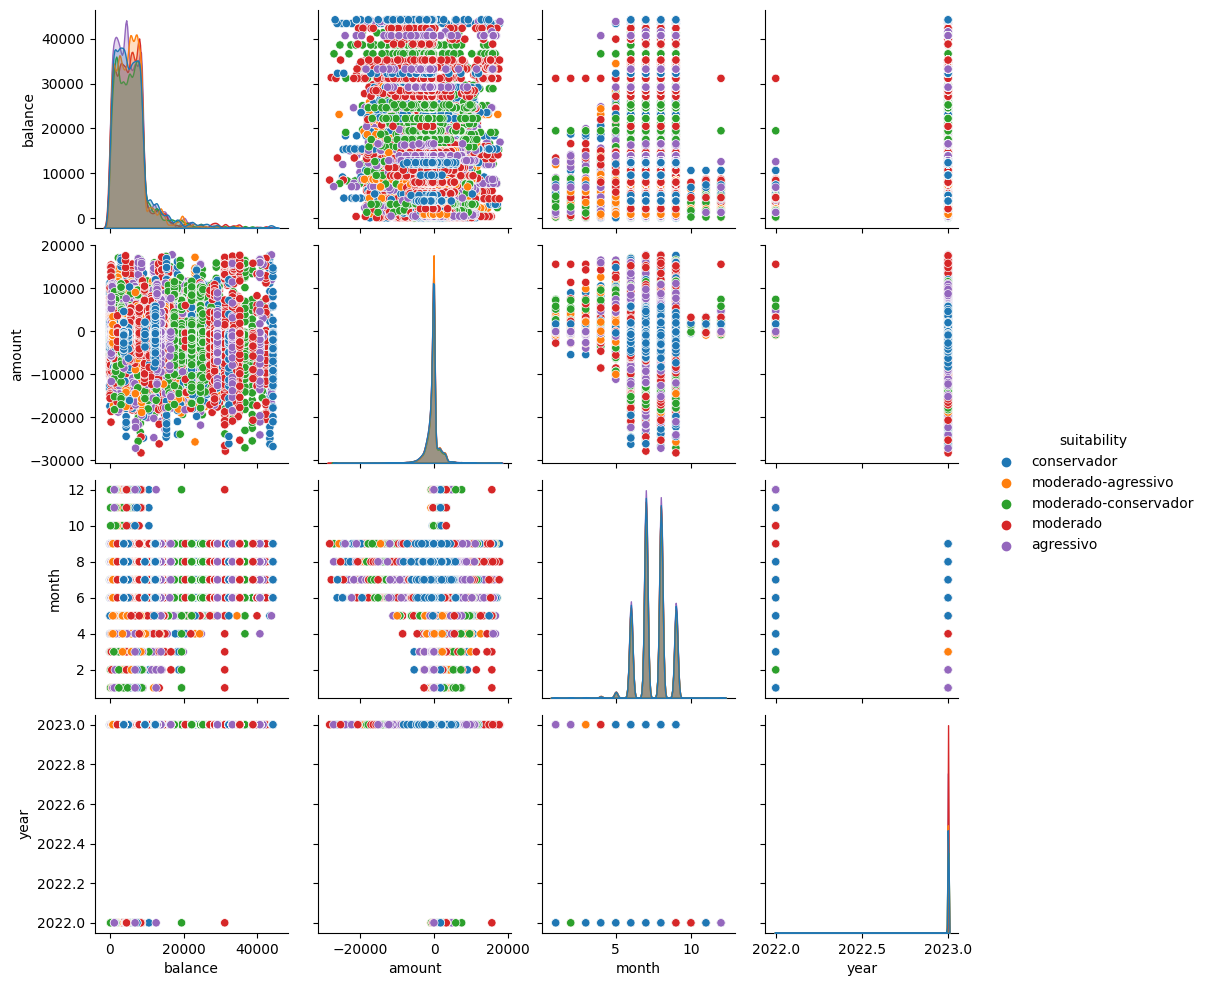

In [307]:
sns.pairplot(merged_data_total, hue='suitability')

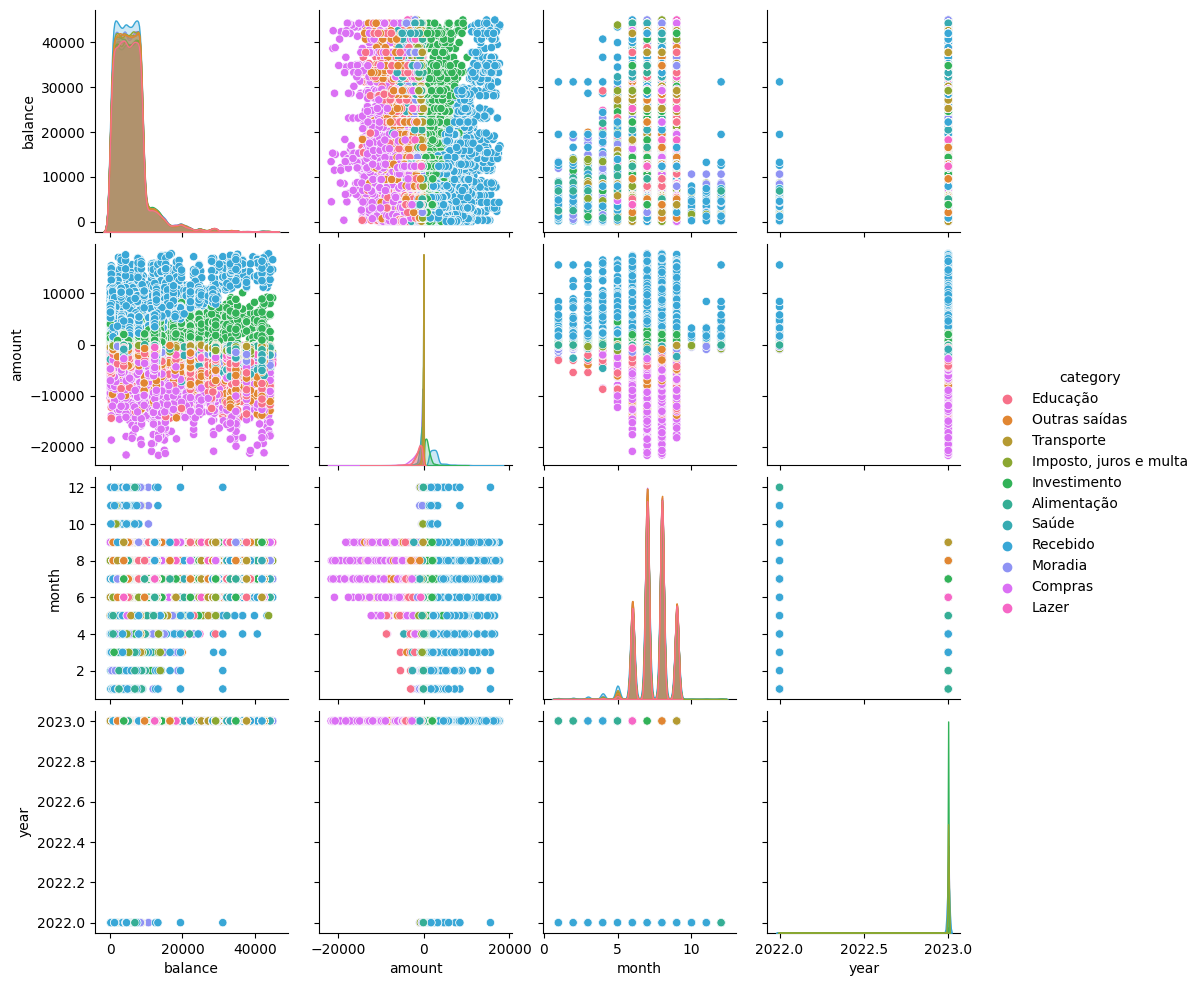

In [308]:
sns.pairplot(merged_data_total, hue='category')

In [309]:
def boxplot(x, y, data):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))

    sns.boxplot(x=x, y=y, data=data)

    plt.title("Box Plot of Account Balances by Subtype")
    plt.xlabel("Subtype")
    plt.ylabel("Balance")

    plt.show()

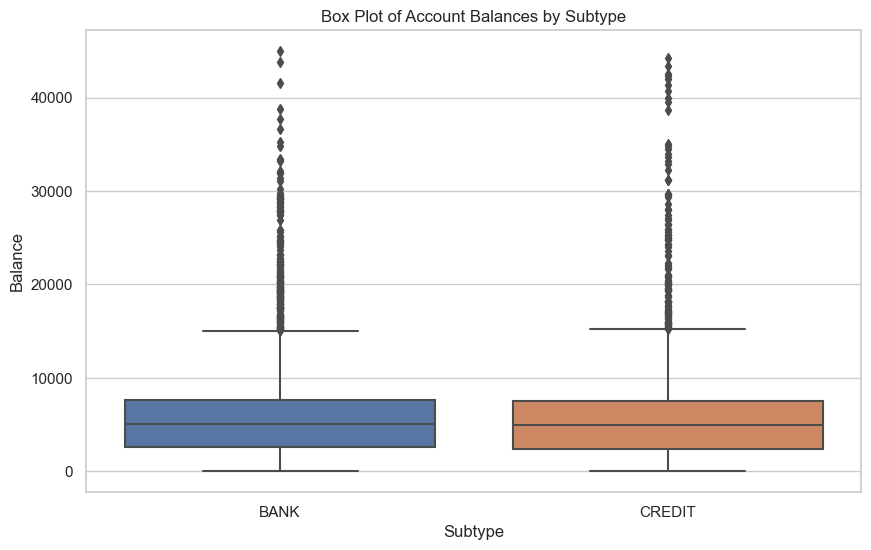

In [310]:
boxplot(x='type', y='balance', data=accounts)

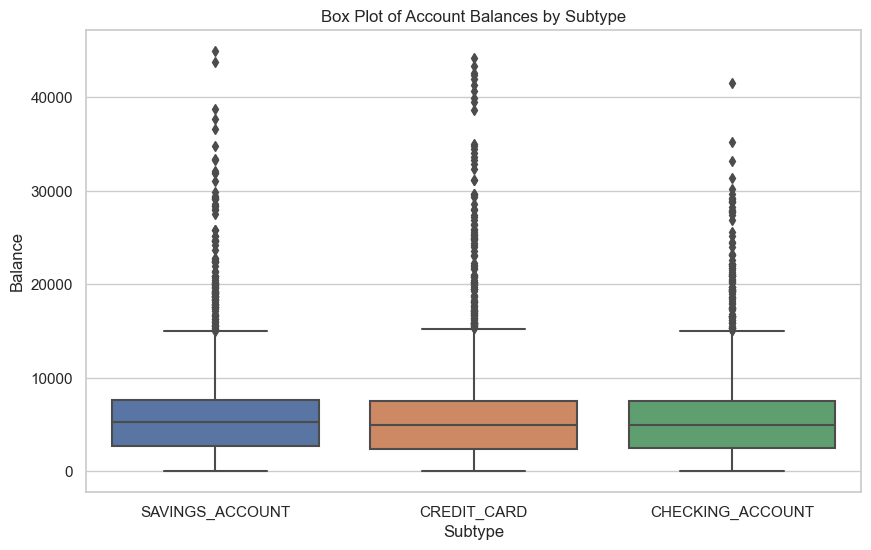

In [311]:
boxplot(x='subtype', y='balance', data=accounts)

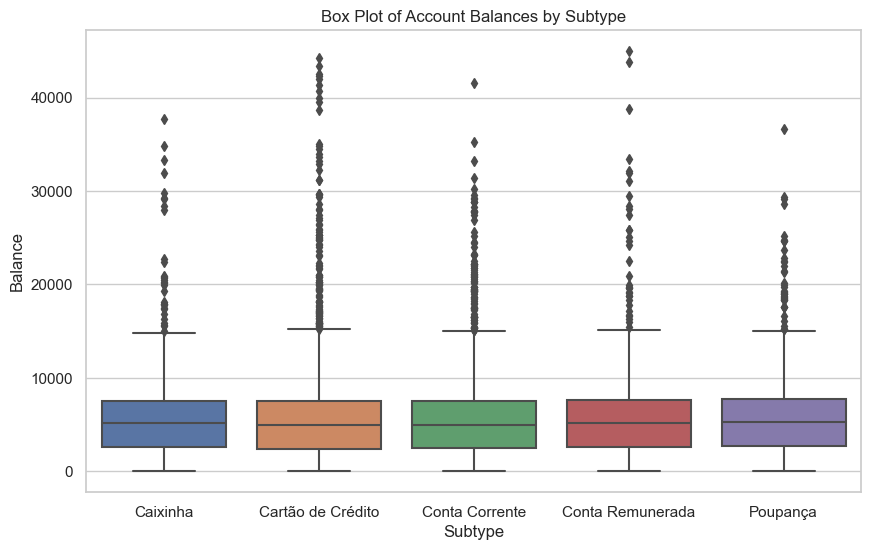

In [312]:
boxplot(x='name', y='balance', data=accounts)

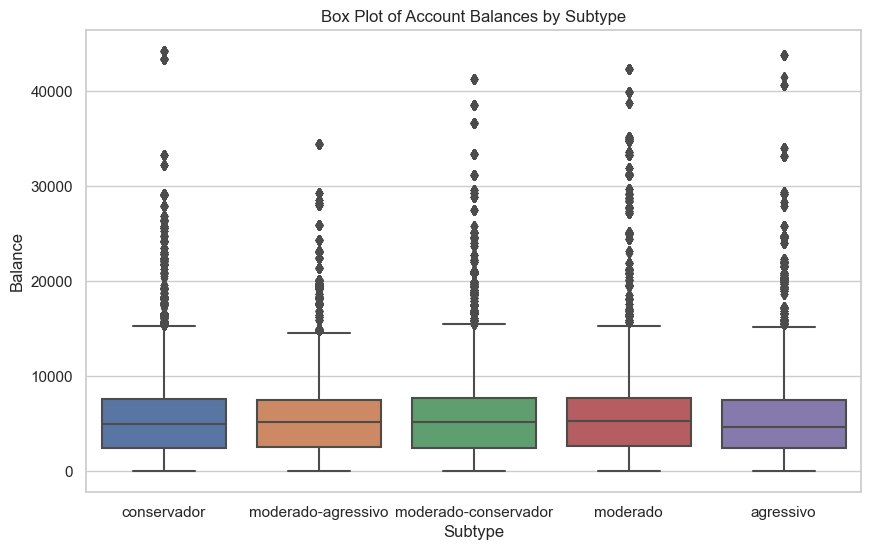

In [313]:
boxplot(x='suitability', y='balance', data=merged_data_total)

In [354]:
merged_data_total.columns

Index(['id_person', 'name_person', 'suitability', 'person_name', 'id_acc',
       'type', 'subtype', 'balance', 'name_acc', 'person_id', 'date', 'id',
       'amount', 'date_trans', 'category', 'account_id', 'month', 'year',
       'year_month'],
      dtype='object')

In [357]:
merged_data_total["date_trans"] = pd.to_datetime(merged_data_total["date_trans"])
merged_data_total["date_trans_dt"] = merged_data_total["date_trans"].map(lambda x:x.date)

In [364]:
merged_data_total.columns

Index(['id_person', 'name_person', 'suitability', 'person_name', 'id_acc',
       'type', 'subtype', 'balance', 'name_acc', 'person_id', 'date', 'id',
       'amount', 'date_trans', 'category', 'account_id', 'month', 'year',
       'year_month', 'date_trans_dt'],
      dtype='object')

In [380]:
merged_data_total.category.unique()

array(['Educação', 'Outras saídas', 'Transporte',
       'Imposto, juros e multa', 'Investimento', 'Alimentação', nan,
       'Saúde', 'Recebido', 'Moradia', 'Compras', 'Lazer'], dtype=object)

In [381]:
a = merged_data_total[merged_data_total.category != 'Recebido']

In [402]:
b = a.groupby(['id_person', 'suitability', 'id_acc', "balance",
                           'id', 'category', 'account_id', 'month', 
                           'year','year_month'])['amount'].sum().reset_index()

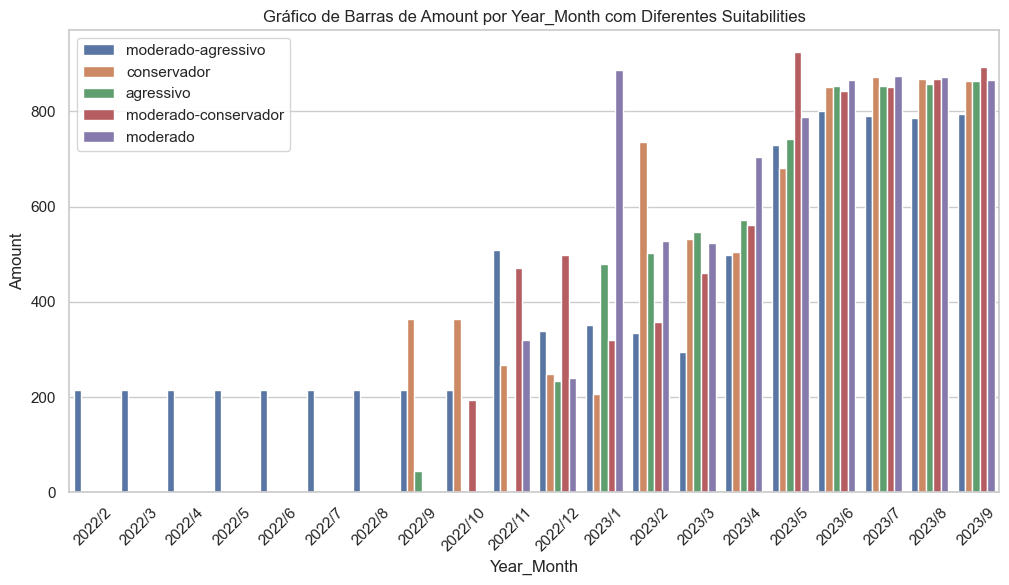

In [406]:
# Certifique-se de que 'b' esteja ordenado corretamente
b = b.sort_values(['year', 'month'])

# Garanta que os valores de 'amount' sejam positivos
b['amount'] = b['amount'].map(lambda x: abs(x))

# Crie o gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(data=b, x='year_month', y='amount', hue='suitability', errorbar=None)

# Personalize o gráfico, se necessário
plt.title('Gráfico de Barras de Amount por Year_Month com Diferentes Suitabilities')
plt.xlabel('Year_Month')
plt.ylabel('Amount')
plt.xticks(rotation=45)

# Mova a legenda para a parte superior direita
plt.legend(loc='upper left')

# Exiba o gráfico
plt.show()

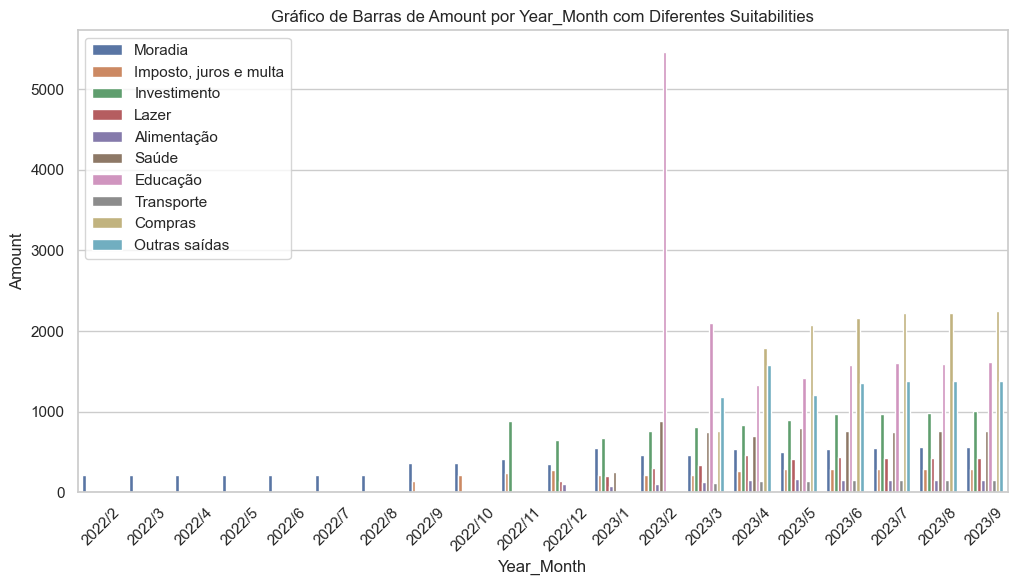

In [398]:
# Certifique-se de que 'b' esteja ordenado corretamente
b = b.sort_values(['year', 'month'])

# Garanta que os valores de 'amount' sejam positivos
b['amount'] = b['amount'].map(lambda x: abs(x))

# Crie o gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(data=b, x='year_month', y='amount', hue='category', errorbar=None)

# Personalize o gráfico, se necessário
plt.title('Gráfico de Barras de Amount por Year_Month com Diferentes Suitabilities')
plt.xlabel('Year_Month')
plt.ylabel('Amount')
plt.xticks(rotation=45)

# Mova a legenda para a parte superior direita
plt.legend(loc='upper left')

# Exiba o gráfico
plt.show()

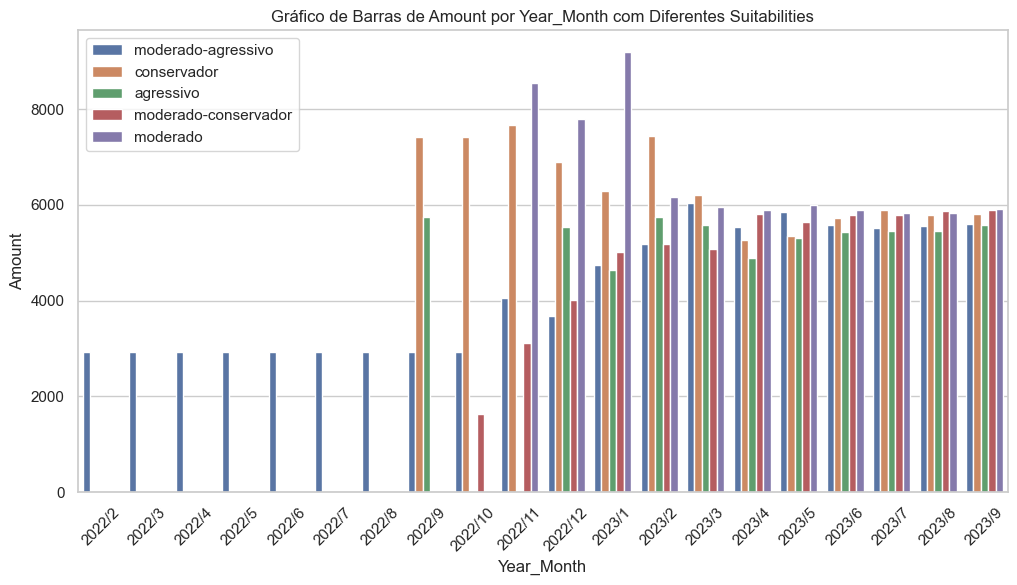

In [399]:
# Certifique-se de que 'b' esteja ordenado corretamente
b = b.sort_values(['year', 'month'])

# Garanta que os valores de 'amount' sejam positivos
b['amount'] = b['amount'].map(lambda x: abs(x))

# Crie o gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(data=b, x='year_month', y='balance', hue='suitability', errorbar=None)

# Personalize o gráfico, se necessário
plt.title('Gráfico de Barras de Amount por Year_Month com Diferentes Suitabilities')
plt.xlabel('Year_Month')
plt.ylabel('Amount')
plt.xticks(rotation=45)

# Mova a legenda para a parte superior direita
plt.legend(loc='upper left')

# Exiba o gráfico
plt.show()

In [409]:
a_gasto

,id_person,suitability,type,subtype,balance,name_acc,id,amount,date_trans,category,account_id,date,month,year,year_month
0,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,BANK,SAVINGS_ACCOUNT,3826.72,Caixinha,b7ebd81b-98f7-47ab-91f3-52bc80be57a6,-498.71,2023-07-20 03:57:57,Educação,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-07-20 03:57:57,7,2023,2023/7
1,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,BANK,SAVINGS_ACCOUNT,3826.72,Caixinha,b8d83679-02ab-4241-b15d-11e9c0033864,-265.00,2023-07-23 05:17:06,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-07-23 05:17:06,7,2023,2023/7
2,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,BANK,SAVINGS_ACCOUNT,3826.72,Caixinha,99cab263-da5c-4706-9f2c-92cb779acaf7,-18.95,2023-06-26 05:54:25,Transporte,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-06-26 05:54:25,6,2023,2023/6
3,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,BANK,SAVINGS_ACCOUNT,3826.72,Caixinha,5a78f1f0-f541-440f-9d3d-c8c21373ffc8,-262.70,2023-06-21 00:34:08,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-06-21 00:34:08,6,2023,2023/6
4,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,BANK,SAVINGS_ACCOUNT,3826.72,Caixinha,fc4e9552-bb41-4757-8c16-ff2c584ee01b,-179.44,2023-08-05 01:09:42,"Imposto, juros e multa",1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-08-05 01:09:42,8,2023,2023/8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400104,fabc96ce-3723-42dc-8cbe-0aba93fcd773,conservador,BANK,SAVINGS_ACCOUNT,3788.95,Poupança,f80b332d-06b8-4286-8357-abc066526806,-596.38,2023-07-05 16:09:08,"Imposto, juros e multa",9ba71d75-2913-4b7b-b2e8-48acbd23c36b,2023-07-05 16:09:08,7,2023,2023/7
400105,fabc96ce-3723-42dc-8cbe-0aba93fcd773,conservador,BANK,SAVINGS_ACCOUNT,3788.95,Poupança,d1297b29-1168-4f15-b856-fc252375d4f7,-735.58,2023-06-20 15:23:59,Lazer,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,2023-06-20 15:23:59,6,2023,2023/6
400106,fabc96ce-3723-42dc-8cbe-0aba93fcd773,conservador,BANK,SAVINGS_ACCOUNT,3788.95,Poupança,bf174dd6-91b9-4b52-b847-cf814accdb07,-1205.81,2023-07-12 21:32:39,Saúde,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,2023-07-12 21:32:39,7,2023,2023/7
400107,fabc96ce-3723-42dc-8cbe-0aba93fcd773,conservador,BANK,SAVINGS_ACCOUNT,3788.95,Poupança,b6714ac1-9299-4fb0-bfe8-4ce4bc98604f,-921.22,2023-07-27 11:48:53,Saúde,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,2023-07-27 11:48:53,7,2023,2023/7


C:\Users\pedro\AppData\Local\Temp\ipykernel_22020\1944686823.py:7: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.



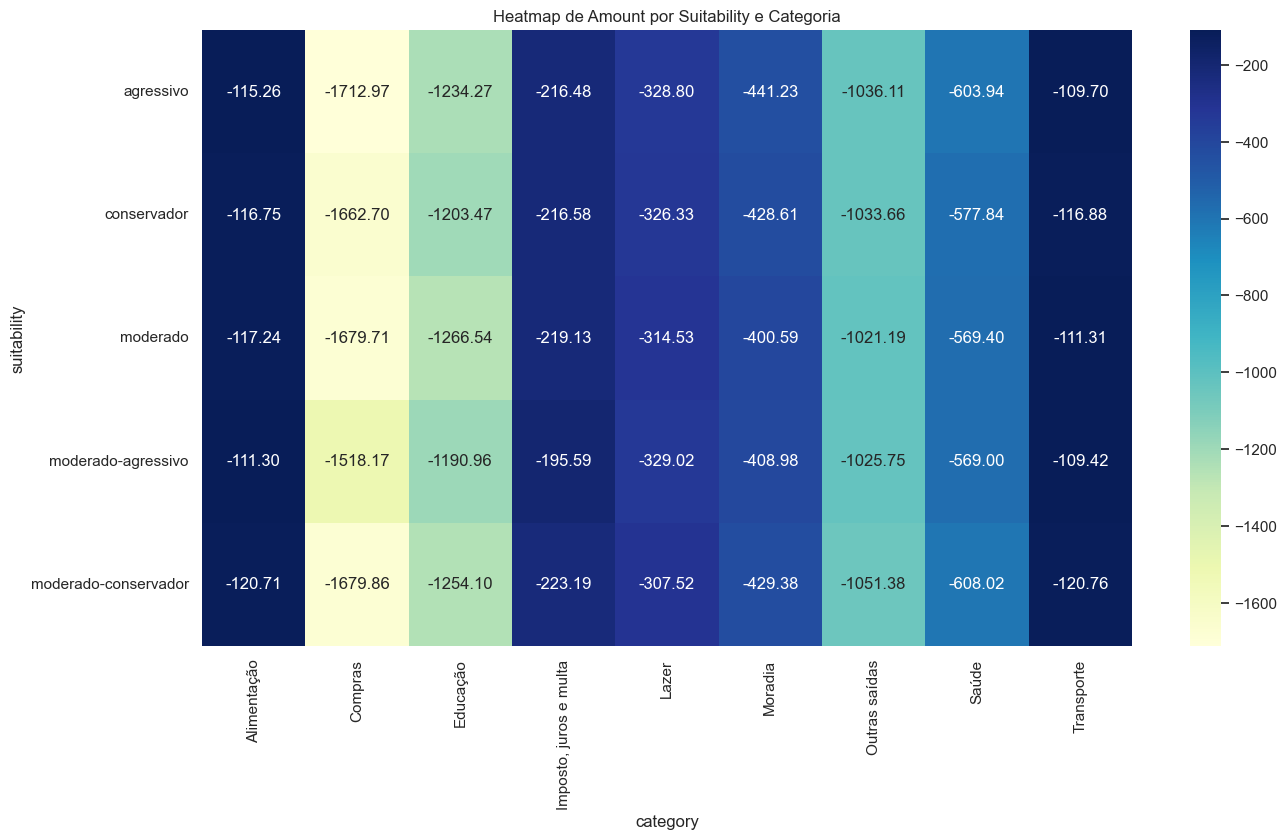

In [408]:
a_gasto_b = a_gasto[a_gasto.year_month == a_gasto.year_month.max()]

# Agregar os dados para calcular a soma dos valores 'amount'
agg_data = a_gasto_b.groupby(['suitability', 'category'])['amount'].median().reset_index()

# Criar um pivot table para formatar os dados para o heatmap
pivot_data = agg_data.pivot('suitability', 'category', 'amount')

# Criar o heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(pivot_data, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title('Heatmap de Amount por Suitability e Categoria')
plt.show()

### 2. Criar uma nova feature que identifique se as transações se referem a gastos fixos ou variáveis.

In [254]:
def transaction_periodicity(df, transaction_to_check=None):
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['year_month'] = df['year'].astype(str) + "/" + df['month'].astype(str)

    grouped = df.groupby(['category', 'account_id', 'year_month'])['amount'].mean().reset_index()
    grouped_count = df.groupby(['category', 'account_id', 'amount'])['year_month'].count().reset_index()

    df = df.merge(grouped, on=['category', 'account_id', 'year_month'], suffixes=('', '_mean'))
    df = df.merge(grouped_count, on=['category', 'account_id', 'amount'], suffixes=('', '_count'))

    df['fixed_expense'] = False
    df.loc[(df['amount'] == df['amount_mean']) & (df['year_month_count'] != 1), 'fixed_expense'] = True
    
    if transaction_to_check is not None:
        if transaction_to_check is not None:
            transaction = df[df['id'] == transaction_to_check]
            if not transaction.empty:
                category = transaction['category'].values[0]
                expense_type = 'Fixa' if transaction['fixed_expense'].values[0] else 'Variável'
                return f"A transação {transaction_to_check}, da categoria {category}, é {expense_type}"
            else:
                return "Transação não encontrada."
    return df


In [256]:
# Exemplo:
transaction_periodicity(transactions,"25d75edf-c379-41af-ac44-794346c7ba46")

'A transação 25d75edf-c379-41af-ac44-794346c7ba46, da categoria Outras saídas, é Fixa'

In [227]:
df = transactions[transactions.amount < 0]
transaction_periodicity(transactions)

,id,amount,date,category,account_id,month,year,year_month,amount_mean,year_month_count,fixed_expense
0,b7ebd81b-98f7-47ab-91f3-52bc80be57a6,-498.71,2023-07-20 03:57:57,Educação,1968bd13-dd25-4f88-bccc-5cff92d6811b,7,2023,2023/7,-890.290000,1,False
1,d8fc8050-f201-4037-bde3-18d17d1d38b6,-1553.85,2023-07-02 17:14:39,Educação,1968bd13-dd25-4f88-bccc-5cff92d6811b,7,2023,2023/7,-890.290000,1,False
2,53073dc0-8aab-4297-8129-83402df68c22,-618.31,2023-07-15 06:51:56,Educação,1968bd13-dd25-4f88-bccc-5cff92d6811b,7,2023,2023/7,-890.290000,1,False
3,b8d83679-02ab-4241-b15d-11e9c0033864,-265.00,2023-07-23 05:17:06,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b,7,2023,2023/7,-265.000000,1,False
4,99cab263-da5c-4706-9f2c-92cb779acaf7,-18.95,2023-06-26 05:54:25,Transporte,1968bd13-dd25-4f88-bccc-5cff92d6811b,6,2023,2023/6,-18.950000,1,False
...,...,...,...,...,...,...,...,...,...,...,...
400105,bf174dd6-91b9-4b52-b847-cf814accdb07,-1205.81,2023-07-12 21:32:39,Saúde,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,7,2023,2023/7,-1315.826667,1,False
400106,b6714ac1-9299-4fb0-bfe8-4ce4bc98604f,-921.22,2023-07-27 11:48:53,Saúde,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,7,2023,2023/7,-1315.826667,1,False
400107,10906168-8f28-49d0-bc9d-cc0034b52259,-3389.77,2023-09-03 16:45:07,no_category,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,9,2023,2023/9,-3389.770000,1,False
400108,6ca0cd12-46e7-4017-8247-b91df1878858,-177.70,2023-09-04 06:35:24,Transporte,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,9,2023,2023/9,-177.700000,1,False


### 3. Clustering para segmentar os clientes em diferentes perfis de gastos.

In [327]:
merged_data_total

,id_person,name_person,suitability,person_name,id_acc,type,subtype,balance,name_acc,person_id,date,id,amount,date_trans,category,account_id,month,year,year_month
0,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,Ana Julia Santos,conservador,Ana Julia Santos,1968bd13-dd25-4f88-bccc-5cff92d6811b,BANK,SAVINGS_ACCOUNT,3826.72,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-07-20 03:57:57,b7ebd81b-98f7-47ab-91f3-52bc80be57a6,-498.71,2023-07-20 03:57:57,Educação,1968bd13-dd25-4f88-bccc-5cff92d6811b,7,2023,2023/7
1,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,Ana Julia Santos,conservador,Ana Julia Santos,1968bd13-dd25-4f88-bccc-5cff92d6811b,BANK,SAVINGS_ACCOUNT,3826.72,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-07-23 05:17:06,b8d83679-02ab-4241-b15d-11e9c0033864,-265.00,2023-07-23 05:17:06,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b,7,2023,2023/7
2,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,Ana Julia Santos,conservador,Ana Julia Santos,1968bd13-dd25-4f88-bccc-5cff92d6811b,BANK,SAVINGS_ACCOUNT,3826.72,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-06-26 05:54:25,99cab263-da5c-4706-9f2c-92cb779acaf7,-18.95,2023-06-26 05:54:25,Transporte,1968bd13-dd25-4f88-bccc-5cff92d6811b,6,2023,2023/6
3,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,Ana Julia Santos,conservador,Ana Julia Santos,1968bd13-dd25-4f88-bccc-5cff92d6811b,BANK,SAVINGS_ACCOUNT,3826.72,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-06-21 00:34:08,5a78f1f0-f541-440f-9d3d-c8c21373ffc8,-262.70,2023-06-21 00:34:08,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b,6,2023,2023/6
4,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,Ana Julia Santos,conservador,Ana Julia Santos,1968bd13-dd25-4f88-bccc-5cff92d6811b,BANK,SAVINGS_ACCOUNT,3826.72,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-08-05 01:09:42,fc4e9552-bb41-4757-8c16-ff2c584ee01b,-179.44,2023-08-05 01:09:42,"Imposto, juros e multa",1968bd13-dd25-4f88-bccc-5cff92d6811b,8,2023,2023/8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400105,fabc96ce-3723-42dc-8cbe-0aba93fcd773,Maria Clara Pereira,conservador,Maria Clara Pereira,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,BANK,SAVINGS_ACCOUNT,3788.95,Poupança,fabc96ce-3723-42dc-8cbe-0aba93fcd773,2023-06-20 15:23:59,d1297b29-1168-4f15-b856-fc252375d4f7,-735.58,2023-06-20 15:23:59,Lazer,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,6,2023,2023/6
400106,fabc96ce-3723-42dc-8cbe-0aba93fcd773,Maria Clara Pereira,conservador,Maria Clara Pereira,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,BANK,SAVINGS_ACCOUNT,3788.95,Poupança,fabc96ce-3723-42dc-8cbe-0aba93fcd773,2023-07-12 21:32:39,bf174dd6-91b9-4b52-b847-cf814accdb07,-1205.81,2023-07-12 21:32:39,Saúde,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,7,2023,2023/7
400107,fabc96ce-3723-42dc-8cbe-0aba93fcd773,Maria Clara Pereira,conservador,Maria Clara Pereira,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,BANK,SAVINGS_ACCOUNT,3788.95,Poupança,fabc96ce-3723-42dc-8cbe-0aba93fcd773,2023-07-27 11:48:53,b6714ac1-9299-4fb0-bfe8-4ce4bc98604f,-921.22,2023-07-27 11:48:53,Saúde,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,7,2023,2023/7
400108,fabc96ce-3723-42dc-8cbe-0aba93fcd773,Maria Clara Pereira,conservador,Maria Clara Pereira,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,BANK,SAVINGS_ACCOUNT,3788.95,Poupança,fabc96ce-3723-42dc-8cbe-0aba93fcd773,2023-07-23 07:10:14,35c6a2bd-c6d7-450a-910b-cf323b444dbf,-2767.55,2023-07-23 07:10:14,Compras,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,7,2023,2023/7


In [329]:
merged_data_total.columns

Index(['id_person', 'name_person', 'suitability', 'person_name', 'id_acc',
       'type', 'subtype', 'balance', 'name_acc', 'person_id', 'date', 'id',
       'amount', 'date_trans', 'category', 'account_id', 'month', 'year',
       'year_month'],
      dtype='object')

In [345]:
merged_data_total_dms = merged_data_total[['suitability', 'name_acc','amount', 'category']]
merged_data_total_dummies = pd.get_dummies(merged_data_total_dms, columns=['category', 'suitability','name_acc'], drop_first=True)
merged_data_total_dummies.head()

,amount,category_Compras,category_Educação,"category_Imposto, juros e multa",category_Investimento,category_Lazer,category_Moradia,category_Outras saídas,category_Recebido,category_Saúde,category_Transporte,suitability_conservador,suitability_moderado,suitability_moderado-agressivo,suitability_moderado-conservador,name_acc_Cartão de Crédito,name_acc_Conta Corrente,name_acc_Conta Remunerada,name_acc_Poupança
0,-498.71,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,-265.00,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
2,-18.95,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
3,-262.70,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
4,-179.44,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


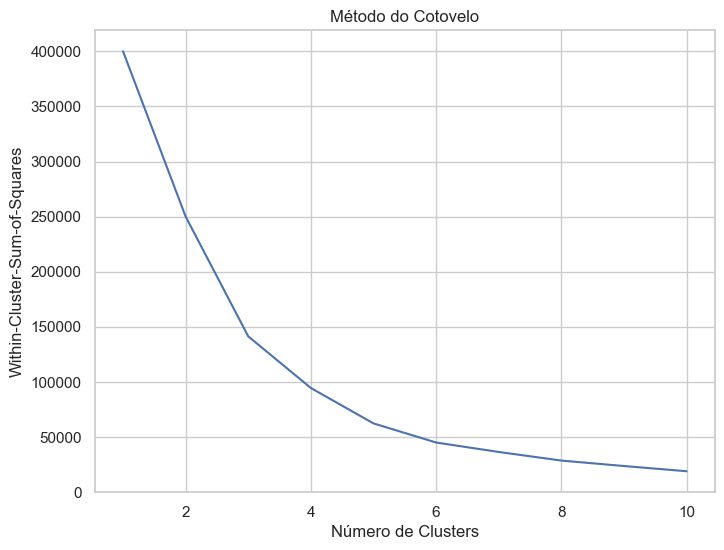

C:\Users\pedro\AppData\Local\Temp\ipykernel_22020\1611457299.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



         amount  cluster  suitability
0       -498.71        2  conservador
1       -265.00        2  conservador
2        -18.95        2  conservador
3       -262.70        2  conservador
4       -179.44        2  conservador
...         ...      ...          ...
400105  -735.58        2  conservador
400106 -1205.81        2  conservador
400107  -921.22        2  conservador
400108 -2767.55        2  conservador
400109  1970.78        1  conservador

[400110 rows x 3 columns]


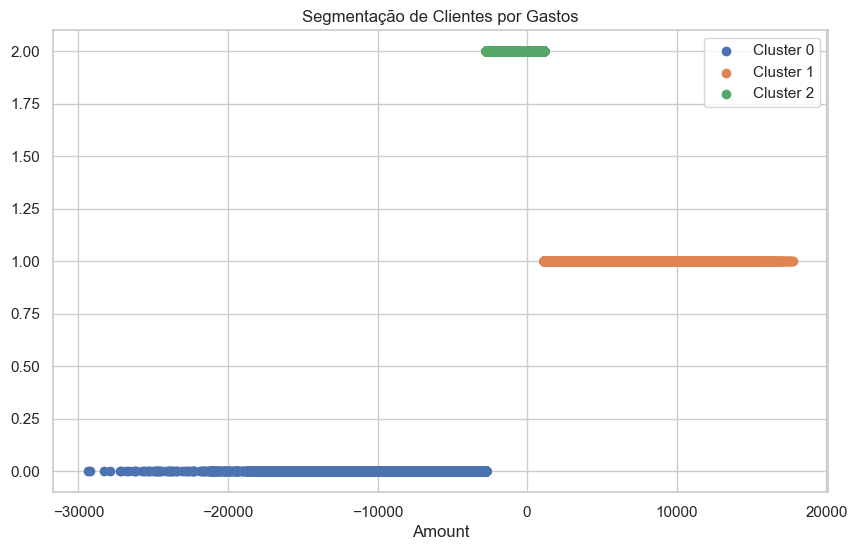

In [410]:
# Carregar os dados
data = merged_data_total_dms  # Substitua 'seu_arquivo.csv' pelo nome do seu arquivo de dados

# Selecionar as colunas relevantes para clustering (por exemplo, 'amount')
X = data[['amount']]

# Normalizar os dados para evitar que a escala afete o resultado do clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Escolher o número de clusters (k) com base no método do cotovelo
wcss = []  # Within-Cluster-Sum-of-Squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plotar o gráfico do método do cotovelo para ajudar a escolher o número ideal de clusters
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss)
plt.title('Método do Cotovelo')
plt.xlabel('Número de Clusters')
plt.ylabel('Within-Cluster-Sum-of-Squares')
plt.show()

# Com base no gráfico do método do cotovelo, escolha o número de clusters (k)
k = 3

# Aplicar o algoritmo K-Means com o número de clusters escolhido
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(X_scaled)

# Adicionar os rótulos dos clusters aos dados originais
data['cluster'] = kmeans.labels_

# Exibir a segmentação dos clientes
segmented_data = data[['amount', 'cluster', "suitability"]]
print(segmented_data)

# Visualizar os clusters
plt.figure(figsize=(10, 6))
for i in range(k):
    plt.scatter(data[data['cluster'] == i]['amount'], 
                [i] * len(data[data['cluster'] == i]), label=f'Cluster {i}')
plt.title('Segmentação de Clientes por Gastos')
plt.xlabel('Amount')
plt.legend()
plt.show()


In [391]:
merged_data_total_dummies.columns

Index(['amount', 'category_Compras', 'category_Educação',
       'category_Imposto, juros e multa', 'category_Investimento',
       'category_Lazer', 'category_Moradia', 'category_Outras saídas',
       'category_Recebido', 'category_Saúde', 'category_Transporte',
       'suitability_conservador', 'suitability_moderado',
       'suitability_moderado-agressivo', 'suitability_moderado-conservador',
       'name_acc_Cartão de Crédito', 'name_acc_Conta Corrente',
       'name_acc_Conta Remunerada', 'name_acc_Poupança', 'cluster'],
      dtype='object')

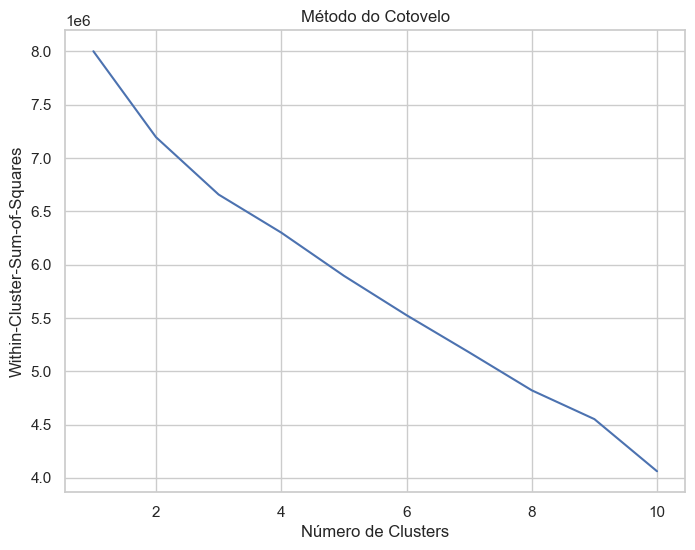

         amount  cluster
0       -498.71        2
1       -265.00        2
2        -18.95        2
3       -262.70        2
4       -179.44        2
...         ...      ...
400105  -735.58        2
400106 -1205.81        2
400107  -921.22        2
400108 -2767.55        2
400109  1970.78        2

[400110 rows x 2 columns]


C:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



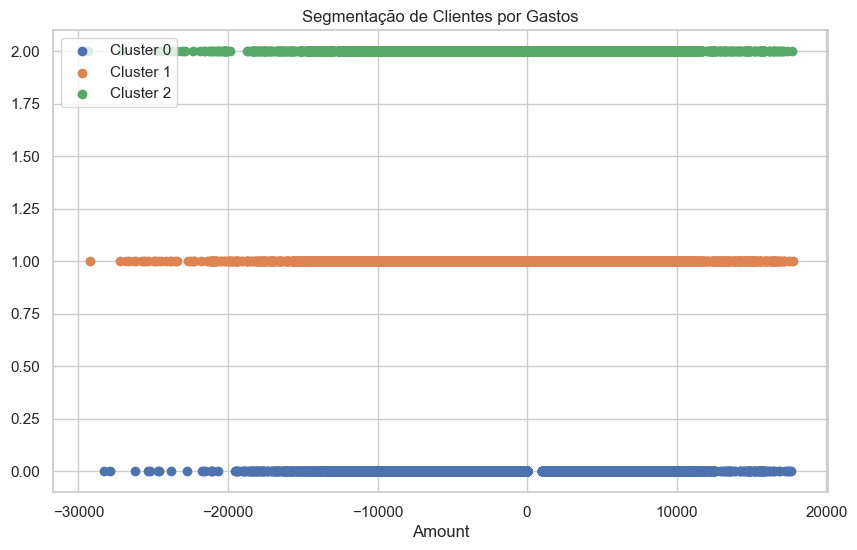

In [390]:
# Carregar os dados
data = merged_data_total_dummies  # Substitua 'seu_arquivo.csv' pelo nome do seu arquivo de dados

# Selecionar as colunas relevantes para clustering (por exemplo, 'amount')
X = merged_data_total_dummies

# Normalizar os dados para evitar que a escala afete o resultado do clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Escolher o número de clusters (k) com base no método do cotovelo
wcss = []  # Within-Cluster-Sum-of-Squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plotar o gráfico do método do cotovelo para ajudar a escolher o número ideal de clusters
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss)
plt.title('Método do Cotovelo')
plt.xlabel('Número de Clusters')
plt.ylabel('Within-Cluster-Sum-of-Squares')
plt.show()

# Com base no gráfico do método do cotovelo, escolha o número de clusters (k)
k = 3

# Aplicar o algoritmo K-Means com o número de clusters escolhido
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(X_scaled)

# Adicionar os rótulos dos clusters aos dados originais
data['cluster'] = kmeans.labels_

# Exibir a segmentação dos clientes
segmented_data = data[['amount', 'cluster']]
print(segmented_data)

# Visualizar os clusters
plt.figure(figsize=(10, 6))
for i in range(k):
    plt.scatter(data[data['cluster'] == i]['amount'], 
                [i] * len(data[data['cluster'] == i]), label=f'Cluster {i}')
plt.title('Segmentação de Clientes por Gastos')
plt.xlabel('Amount')
plt.legend()
plt.show()


### 4. Etiquetar cada cluster identificado com padrões de gastos quanto à quantidade, natureza (fixo/variado) e categoria da compra.

### 5. Responder às seguintes perguntas:
###   - Quais os perfis de clientes que mais gastam proporcionalmente em gastos fixos?
###   - Quais as categorias de compra que mais impactam nos perfis de gasto?
###   - Quais são os perfis centrais (ou típicos) de cada cluster?